In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from seaborn import plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.externals import joblib
from datetime import datetime
import pydotplus
from sklearn.ensemble import VotingClassifier 

%matplotlib inline

/home/aleksandra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
cnx = create_engine('####')

Predict the endstation based on startstation (latitude and longitude), starttime (converted to epoch), birthyear, visibility, drybulbtempc, wetbulbtempc, windspeed, precip.
Only for a subset of the data: female registered users (http://toddwschneider.com/posts/a-tale-of-twenty-two-million-citi-bikes-analyzing-the-nyc-bike-share-system/)

How many rows are there for female registered users?

That's a lot... I will only use the June data in order not to run out of memory.

There are about 300 000 rides for registered female users in the month of June 2016. From this subset, I will only include the rides for which the startstation has endstations that receive over a 10 rides from that given startstation.

In [3]:
data = pd.read_sql_query('''SELECT startstationlatitude, startstationid, startstationname, startstationlongitude, 
visibility, drybulbtempc, wetbulbtempc, windspeed, precip, endstationid, endstationName, birthyear, starttime
FROM bikeshare
INNER JOIN weatherdata ON bikeshare.start_hour = weatherdata.date 
WHERE user_dummy = 1 AND month = 6''', cnx)

Select data from stations that are well represented (at least 1000 rides from and to the station during the month of June), in order to diminish noise.

In [4]:
ends = data.endstationid.value_counts()
busy_stations = ends[ends>1000].index

In [5]:
targets = data[data.endstationid.isin(list(busy_stations))]

In [6]:
targets.shape

(1161193, 13)

In [7]:
starts = data.startstationid.value_counts()
busy_start_stations = ends[ends>1000].index

In [8]:
targets_final = targets[targets.startstationid.isin(list(busy_start_stations))]

In [9]:
targets_final.shape

(1117979, 13)

Start with data from weekdays only. presumably, the expected patterns differ considerably between weekdays (rush hours) and weekends (no rush hours).

In [10]:
targets_final['weekday'] = targets_final['starttime'].dt.dayofweek

/home/aleksandra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
targets_final_wd = targets_final[targets_final.weekday.isin(['0', '1', '2', '3', '4'])]

In [12]:
targets_final_wd['weekday'] = pd.to_numeric(targets_final_wd.weekday)

/home/aleksandra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
targets_final_wd.shape

(897250, 14)

Convert starttime to epoch, in order to be able to unclude it as an independent variable.

In [14]:
targets_final_wd.starttime.head()

4   2016-06-24 08:41:32
5   2016-06-24 10:12:31
6   2016-06-29 14:49:55
7   2016-06-01 07:16:20
8   2016-06-01 13:58:43
Name: starttime, dtype: datetime64[ns]

In [15]:
b = datetime(1970, 1, 1)
targets_final_wd['epoch'] = targets_final_wd.starttime - b
targets_final_wd['epoch'] = targets_final_wd['epoch'].dt.total_seconds()

/home/aleksandra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/aleksandra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
targets_final_wd.columns

Index(['startstationlatitude', 'startstationid', 'startstationname',
       'startstationlongitude', 'visibility', 'drybulbtempc', 'wetbulbtempc',
       'windspeed', 'precip', 'endstationid', 'endstationname', 'birthyear',
       'starttime', 'weekday', 'epoch'],
      dtype='object')

In [19]:
X = targets_final_wd.drop(['startstationid', 'startstationname', 'endstationname', 'endstationid', 'weekday', 
                        'starttime'], 1)
y = targets_final_wd.endstationname
X.head()

,startstationlatitude,startstationlongitude,visibility,drybulbtempc,wetbulbtempc,windspeed,precip,birthyear,epoch
4,40.712199,-73.979481,10.0,22.8,17.5,14.0,0.0,1953,1.466758e+09
5,40.739355,-73.999318,10.0,26.1,20.3,11.0,0.0,1989,1.466763e+09
6,40.712199,-73.979481,10.0,27.2,21.3,3.0,0.0,1978,1.467212e+09
7,40.778627,-73.957721,10.0,-2.8,-5.2,0.0,0.0,1988,1.464765e+09
8,40.755103,-73.974987,10.0,4.4,2.0,5.0,0.0,1991,1.464790e+09


In [18]:
len(y.unique())

350

There are 350 target values. 

# 1. Run all the models to get an idea.
Get an idea of the distribution of the target variable:

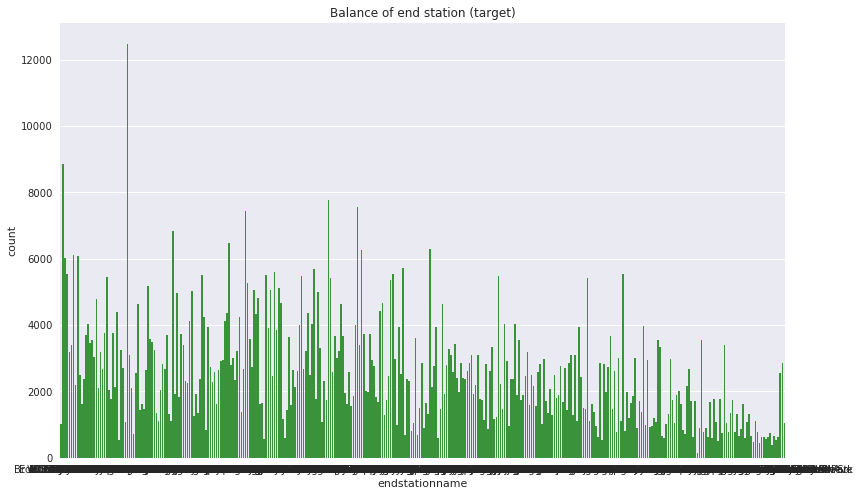

In [19]:
plt.figure(figsize=(13,8))
sns.countplot(y, color='tab:green')
plt.title('Balance of end station (target)')

The target variables is quite unbalanced. I will do a stratified oversampling to balance the dataset.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [ ]:
label_list = list(y_train.unique())

In [21]:
def run_model(model, X_train, y_train, X_test, y_test):
    mod = model
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    cr = metrics.classification_report(y_test, y_pred)
    acs = metrics.accuracy_score(y_test, y_pred)
    cm = metrics.confusion_matrix(y_test, y_pred, labels=list(np.unique(y_train)))
    return cr, acs, cm

## 1.1 Logistic regression

In [23]:
cr_lr, acs_lr, cm_lr = run_model(LogisticRegression(n_jobs = -1, class_weight='balanced'), 
                                 X_train, y_train, X_test, y_test)

/home/aleksandra/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
print(acs_lr)

0.0139091358949


Logistic regression tries to find a line to separate the data. If there is no such line, it will do badly.

## 1.2. KNN

In [25]:
cr_knn, acs_knn, cm_knn = run_model(KNeighborsClassifier(n_jobs = -1, n_neighbors=17, weights='distance'), 
                                    X_train, y_train, X_test, y_test)

In [26]:
k_acc = []
for k in range(1, 50):
    cr_knn, acs_knn, cm_knn = run_model(KNeighborsClassifier(n_jobs = -1, n_neighbors=k, weights='distance'), 
                                        X_train, y_train, X_test, y_test)
    k_acc.append((k, acs_knn))

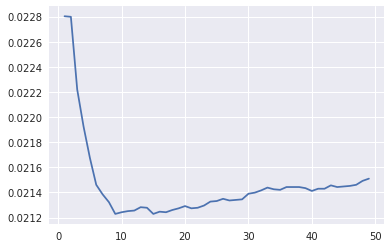

In [27]:
k = [e[0] for e in k_acc]
accs = [e[1] for e in k_acc]
plt.plot(k, accs)

KNN looks at the datapoints nearby. I set the weight parameter to 'distance' in order for more similar datapoints to be more relevant in class decision. The best number of neighbours is 49. Does better than logistic regression.

In [39]:
print(accs[48])

0.021510122017


## 1.3 GaussianNB

In [29]:
cr_gaus, acs_gaus, cm_gaus = run_model(GaussianNB(), X_train, y_train, X_test, y_test)

/home/aleksandra/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
print(acs_gaus)

0.0140740839809


## 1.4 Decision tree

In [21]:
cr_dt, acs_dt, cm_dt = run_model(DecisionTreeClassifier(criterion='entropy', class_weight='balanced'), 
                                 X_train, y_train, X_test, y_test)

In [22]:
print(acs_dt)

0.0624618278923


## 1.5 Random Forests

In [23]:
cr_rf, acs_rf, cm_rf = run_model(RandomForestClassifier(n_jobs = -1, class_weight='balanced'), 
                                 X_train, y_train, X_test, y_test)

In [24]:
print(acs_rf)

0.0556766660871


## 1.6 Confusion matrices for best two models

In [25]:
cms = [cm_dt, cm_rf]

In [26]:
import numpy as np

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """
    plt.figure(figsize=(16,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=90)
    #plt.yticks(tick_marks, classes)
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [27]:
import re
def find_good_stations(pr):
    rows = pr.split('\n')
    scores = [re.split(r'    ', row) for row in rows]
    out = []
    for row in scores:
        scores = []
        for score in row:
            if score !='':
                scores.append(score.strip())
        out.append(scores)
    df_scores = pd.DataFrame(out[2:], columns = ['station', 'precision', 'recall', 'f1', 'support'])
    df_scores.f1 = pd.to_numeric(df_scores.f1)
    df_good_preds = df_scores[df_scores.iloc[:, 3] >= 0.10]
    return df_good_preds

good_rf = find_good_stations(cr_rf)
good_dt = find_good_stations(cr_dt)

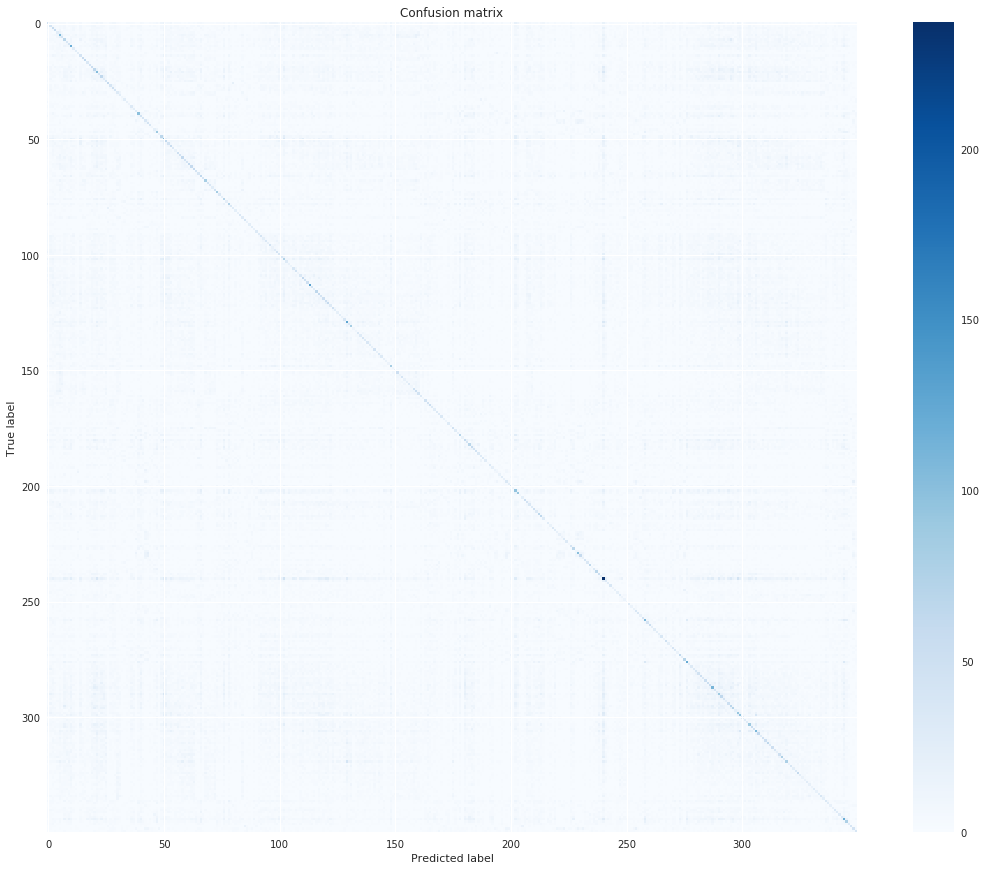

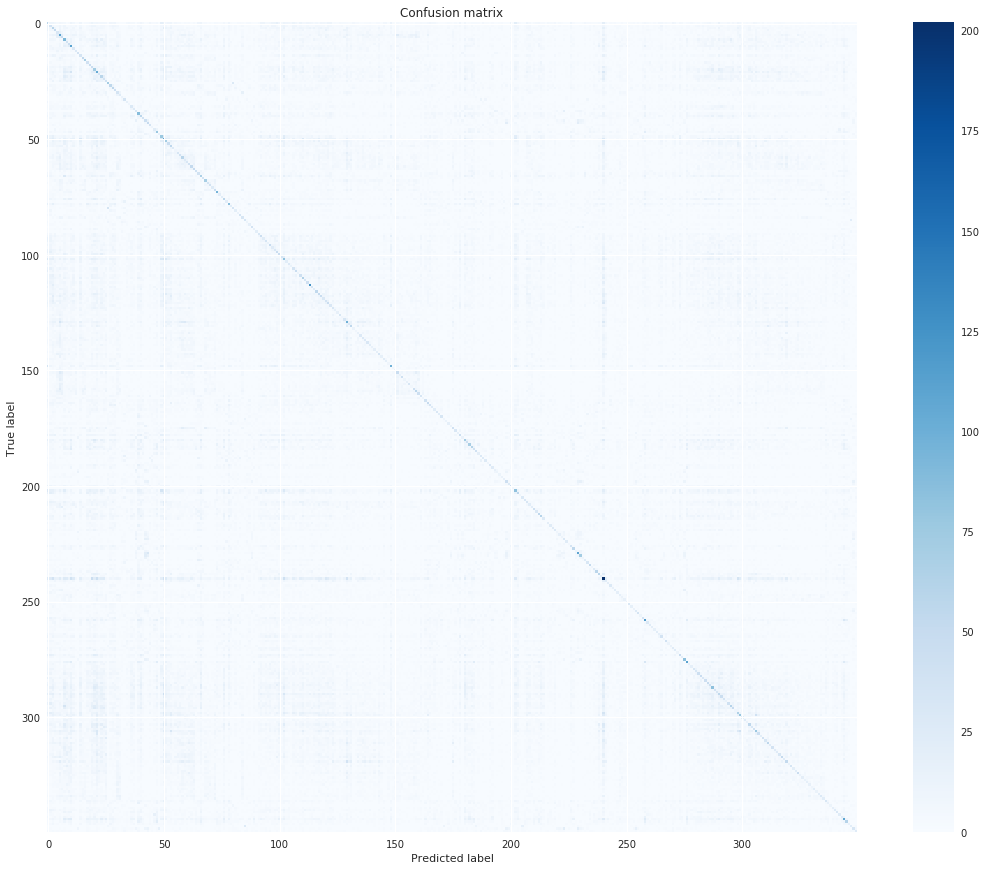

In [30]:
for cm in cms:
    plot_confusion_matrix(cm, label_list)

# 1.7 Diving in
Decision tree and random forests give the best results.
The baseline = 1/92 = 0.01
DT accuracy = 0.09
RF accuracy = 0.07

Next:
* which features are relevant
* for which stations do we have good predictions? Are these simply frequent stations? Is there a pattern?

In [31]:
rf = RandomForestClassifier(n_jobs = -1, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
sorted(list(zip(X_train.columns, rf.feature_importances_)), key = lambda x: x[1])

[('precip', 0.0034506736721810912),
 ('visibility', 0.049109792575629509),
 ('startstationlongitude', 0.058039207516239963),
 ('startstationlatitude', 0.060253257545658703),
 ('windspeed', 0.091901955910132865),
 ('drybulbtempc', 0.10781888094616991),
 ('wetbulbtempc', 0.1366203025286114),
 ('birthyear', 0.19317510845130126),
 ('epoch', 0.29963082085407533)]

In [33]:
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [34]:
sorted(list(zip(X_train.columns, dt.feature_importances_)), key = lambda x: x[1])

[('precip', 0.005248212399443437),
 ('startstationlongitude', 0.016795011260954083),
 ('startstationlatitude', 0.0181525046914464),
 ('visibility', 0.066324011501989577),
 ('birthyear', 0.090578796707861287),
 ('windspeed', 0.1259292433722006),
 ('drybulbtempc', 0.13736444070659992),
 ('wetbulbtempc', 0.18006580134468372),
 ('epoch', 0.35954197801482096)]

The most relevant variables for random forests:
* starttime
* temperature (feel mainly)
* birthyear
* windspeed

The most relevant features for decision trees:
* starttime
* birthyear
* temperature
* windspeed

Questions:
* Relevance of starttime?  
This is probably the working people flows: they always start at the same station at approximately the same time, and go to the same end station.
* Relevance of birthyear?  
Might also be related to the working people flow: people within a certain year interval are working people. Outside of that interval maybe not. Other possibility: younger people tend to be more convicted bike share users?
* Relevance of weather:
    * Feel temperature is more relevant than dry temperature.
    * windspeed is relevant. Of course.
    * why is startstation not very relevant?  
Possible answer: the predicted endstation is just a very frequent one.

### What's special about the good predictions?

In [ ]:
good_stations = good_rf.station.append(good_dt.station)
len(set(good_stations))

In [ ]:
goods = targets_final_wd[targets_final_wd.endstationname.isin(good_stations)]

In [52]:
goods.columns

Index(['startstationlatitude', 'startstationid', 'startstationname',
       'startstationlongitude', 'visibility', 'drybulbtempc', 'wetbulbtempc',
       'windspeed', 'precip', 'endstationid', 'endstationname', 'birthyear',
       'starttime', 'weekday', 'epoch'],
      dtype='object')

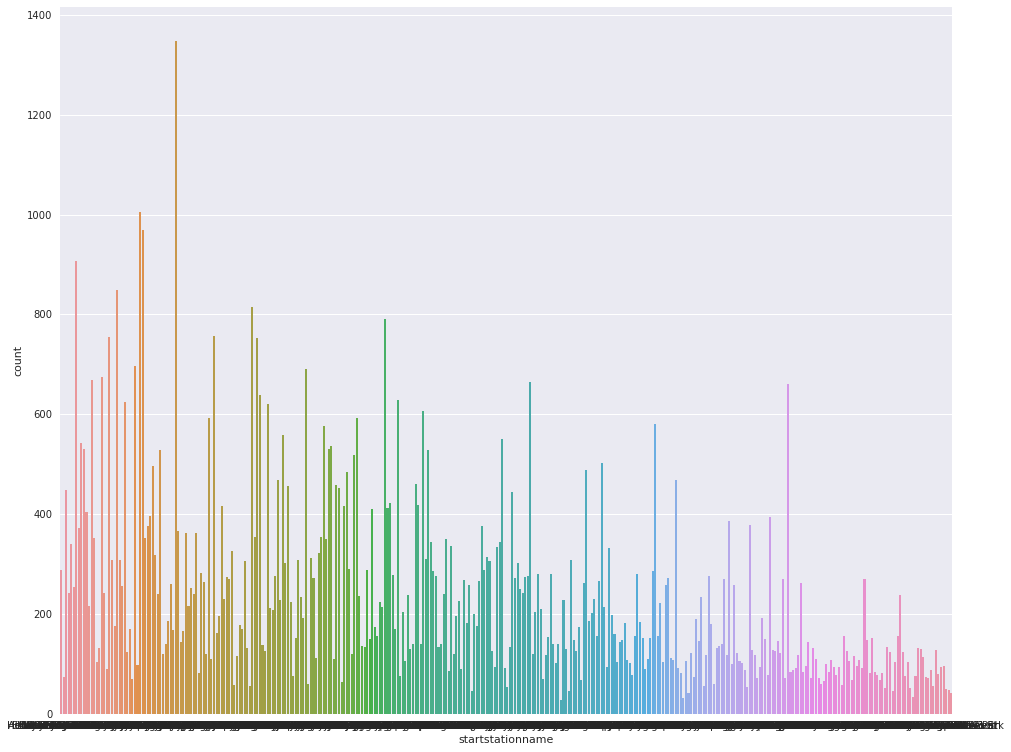

In [54]:
plt.figure(figsize=(16,13))
sns.countplot(goods.startstationname)

There is a lot of variation: some start stations are very frequent, others are not.

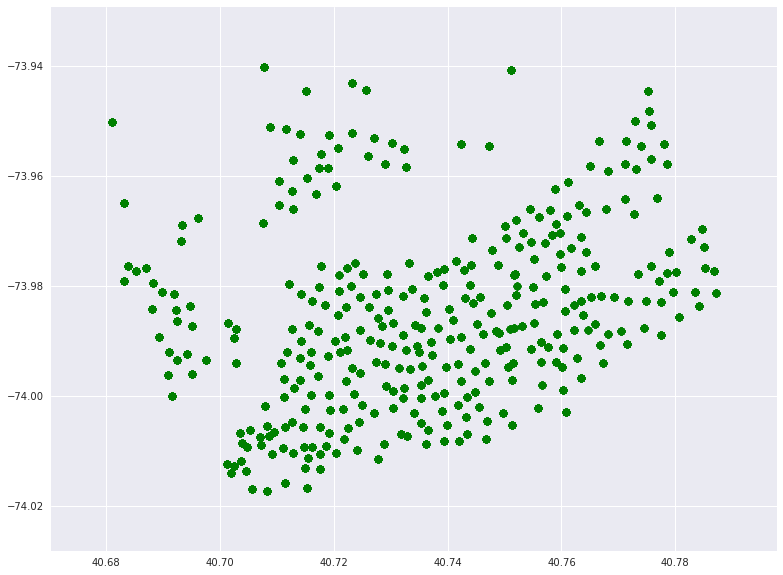

In [57]:
plt.figure(figsize=(13, 10))
plt.scatter(goods.startstationlatitude, goods.startstationlongitude, c='g')

The startstations are concentrated in three areas.

# 2. Refining the models
## 2.1 Decision trees

Gridsearch playing around with n_samples and depth

In [35]:
dt.get_params()

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [36]:
parameters = {'max_depth': range(5, 20), 'min_samples_split' : range(2, 10, 2), 'criterion': ['gini', 'entropy']}
clf = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), parameters, n_jobs = -1)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(5, 20), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [37]:
print("Best parameters set found on development set: \n")
print(clf.best_params_)

Best parameters set found on development set: 

{'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 2}


In [23]:
cr_dt2, acs_dt2, cmdt2 = run_model(DecisionTreeClassifier(max_depth = 16, min_samples_split=2, class_weight='balanced',
                                                         criterion='entropy'), X_train, y_train, X_test, y_test)

In [24]:
print(acs_dt2)

0.0727376478403


## 2.2 Random forests
Make more trees.

In [ ]:
cr_rf2, acs_rf2, cmrf2 = run_model(RandomForestClassifier(n_jobs = -1, n_estimators = 100, class_weight='balanced'), 
          X_train, y_train, X_test, y_test)

In [ ]:
print(acs_rf2)

__ Kernel death__

In [ ]:
parameters = {'max_depth': range(5, 20), 'min_samples_split' : range(2, 10, 2), 'criterion': ['entropy', 'gini']}
clf = GridSearchCV(RandomForestClassifier(class_weight='balanced', n_estimators = 100), parameters, n_jobs = -1)
clf.fit(X_train, y_train)

In [ ]:
print("Best parameters set found on development set: \n")
print(clf.best_params_)

In [96]:
cr_rf3, acs_rf3, cmrf3 = run_model(RandomForestClassifier(n_jobs = -1, n_estimators = 100, class_weight='balanced', 
                        max_depth= 17, min_samples_split= 8), X_train, y_train, X_test, y_test)

## 2.4 Voting Classifier
Such a classifier can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

In [21]:
dt_ref = DecisionTreeClassifier(max_depth = 16, min_samples_split=2, class_weight='balanced',
                                                         criterion='entropy')
rf_ref = RandomForestClassifier(n_jobs = -1, n_estimators = 100, class_weight='balanced', 
                        max_depth= 17, min_samples_split= 8, random_state=42)
eclf = VotingClassifier(estimators=[('dt', dt_ref), ('rf', rf_ref)], voting='soft')
eclf.fit(X_train, y_train)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=16, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False...imators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         n_jobs=1, voting='soft', weights=None)

In [ ]:
y_pred = eclf.predict(X_test)
# cr_eclf = metrics.classification_report(y_test, y_pred)
acs_eclf = metrics.accuracy_score(y_test, y_pred)
# cm_eclf = metrics.confusion_matrix(y_test, y_pred, labels=list(np.unique(y_train)))

__Kernel death__

In [1]:
weights = []
for i in range(1, 6):
    for j in range(1, 6):
        if i != j:
            weights.append([i, j])   

In [ ]:
parameters = {'weights': weights}
clf_eclf = GridSearchCV(VotingClassifier(estimators=[('dt', dt_ref), ('rf', rf_ref)], voting='soft'), parameters, 
                        n_jobs = -1)
clf_eclf.fit(X_train, y_train)

In [ ]:
print(clf_eclf.best_params_)